Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
Best score found:  0.591950972269396


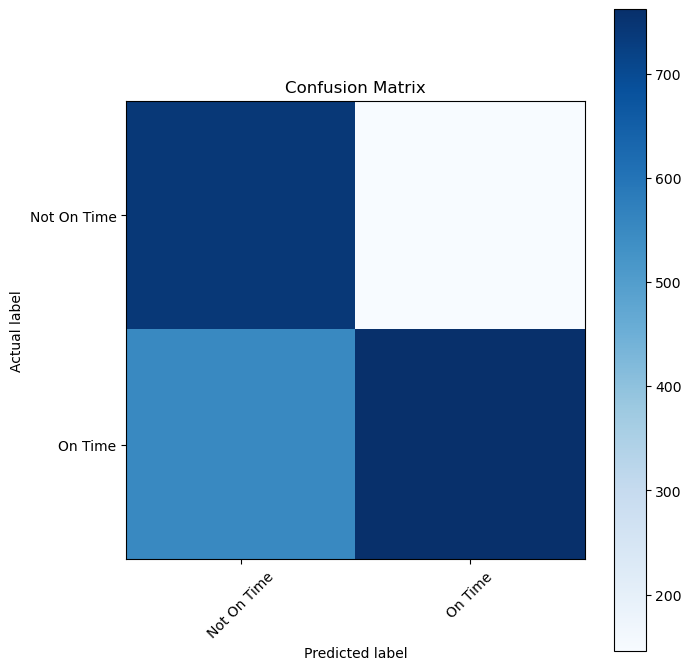

              precision    recall  f1-score   support

           0       0.57      0.84      0.68       887
           1       0.84      0.58      0.69      1313

    accuracy                           0.68      2200
   macro avg       0.71      0.71      0.68      2200
weighted avg       0.73      0.68      0.68      2200



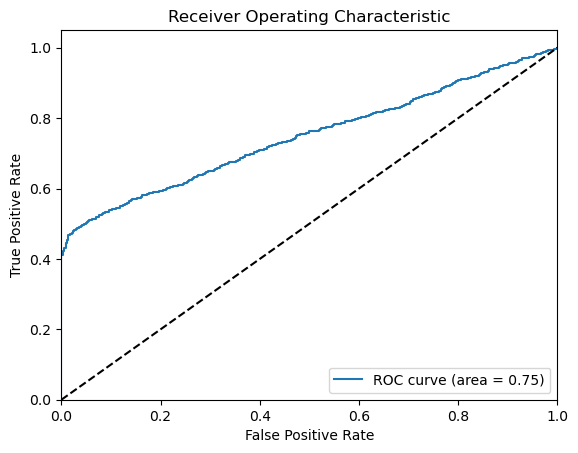

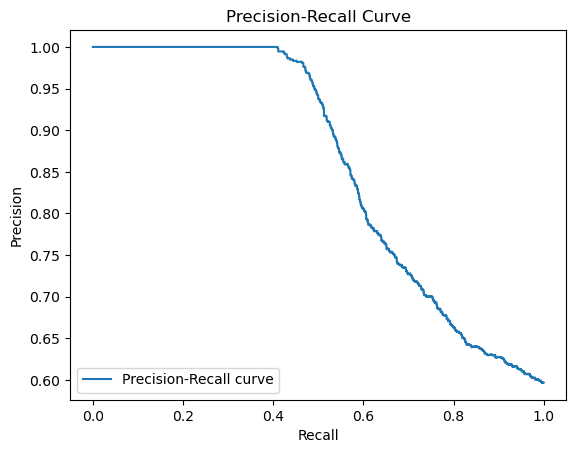

['trained_model.joblib']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from joblib import dump

# Load and preprocess the dataset
df = pd.read_csv(r"C:\Users\anoop\OneDrive\MS\1st Quarter\Data Mining ALY6040\Data mining Project\Train new.csv") 

def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)
df = df.drop(['ID'], axis=1)

# Split the dataset into features and the target variable
X = df.drop(['Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']
cat_features_indices = np.where(X.dtypes != float)[0]

# Hyperparameter tuning setup with GridSearchCV
model = CatBoostClassifier(task_type='CPU', verbose=0)  # Use 'GPU' for GPU support if possible

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 500, 1000],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X, y, cat_features=cat_features_indices)

print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Evaluation setup (assuming a test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_model.fit(X_train, y_train, cat_features=cat_features_indices, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=False)

# Evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not On Time', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Not On Time', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
dump(best_model, 'trained_model.joblib')